# German Credit Risk Evaluation

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from scipy.stats import shapiro, probplot, f_oneway
from sklearn.preprocessing import LabelEncoder

In [11]:
credit = pd.read_csv('german_credit_data.csv', index_col=0)
credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


#### Column Description
Age: numerical

Sex: categorical (Male, Female)

Job: categorical labelled as numerical (0>> unskilled and non-resident, 1>>unskilled resident, 2>>skilled, 3>>highly skilled)

Housing: categorical (own, rent, free)

Saving accounts: text (NaN,little, moderate, quite rich, rich)

Checking account: text (NaN,little, moderate, quite rich, rich)

Credit amount: numerical in Duestche Mark

Duration: numerical in months

Purpose: categorical (car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacations/others)

In [12]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [13]:
credit['Saving accounts'].fillna('No Account Info', inplace=True)
credit['Checking account'].fillna('No Account Info', inplace=True)

In [14]:
credit.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
dtype: int64

### General Exploration

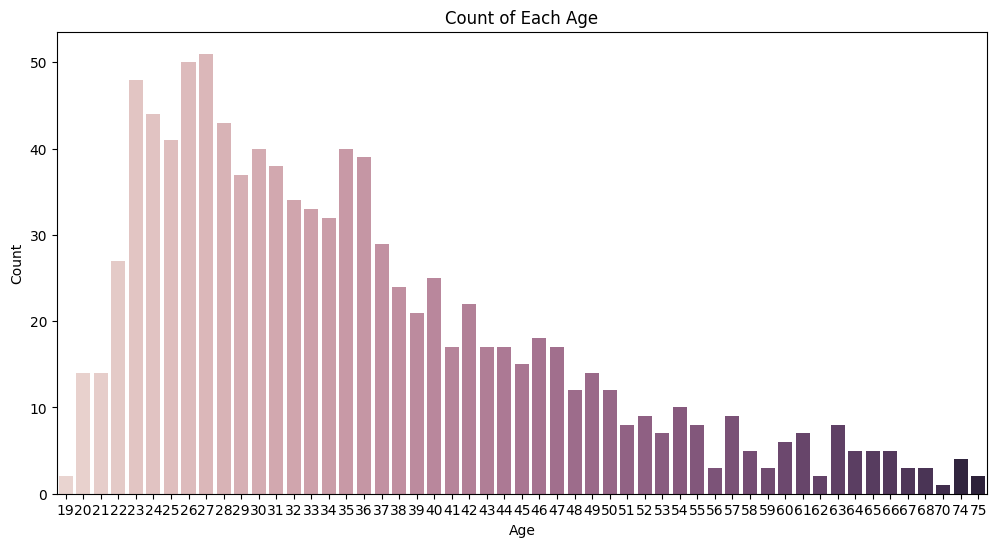

In [15]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Create a count plot for the 'Age' column
sns.countplot(x='Age', data=credit, hue='Age', legend=False)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of Each Age')

# Show the plot
plt.show()

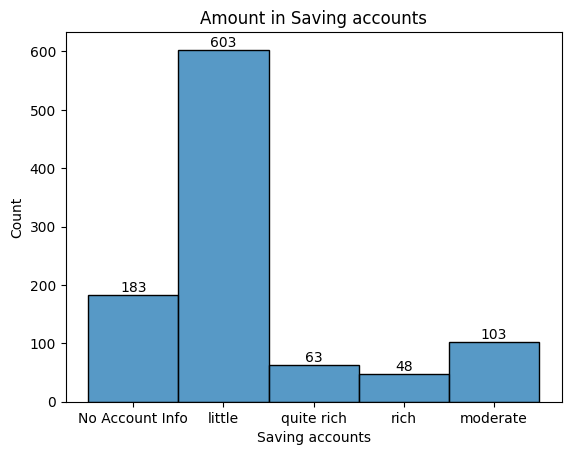

In [16]:
saving_count = credit['Saving accounts'].value_counts()
saving_hist = sns.histplot(credit['Saving accounts'])
plt.title('Amount in Saving accounts')
for index, value in saving_count.items():
    saving_hist.text(index, value, f'{value}', ha='center', va='bottom')
plt.show()

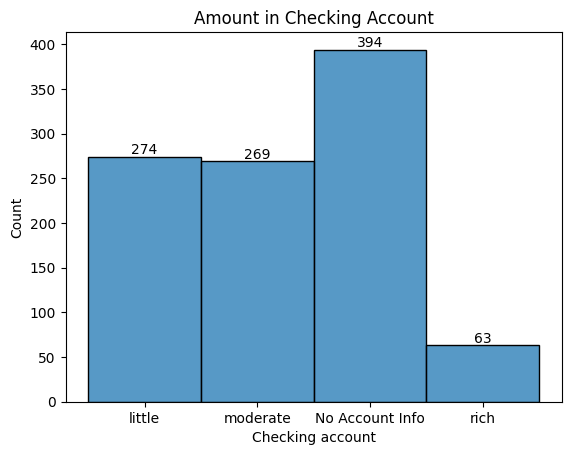

In [17]:
checking_count = credit['Checking account'].value_counts()
checking_hist = sns.histplot(credit['Checking account'])
plt.title('Amount in Checking Account')
for index, value in checking_count.items():
    checking_hist.text(index, value, f'{value}', ha='center', va='bottom')
plt.show()

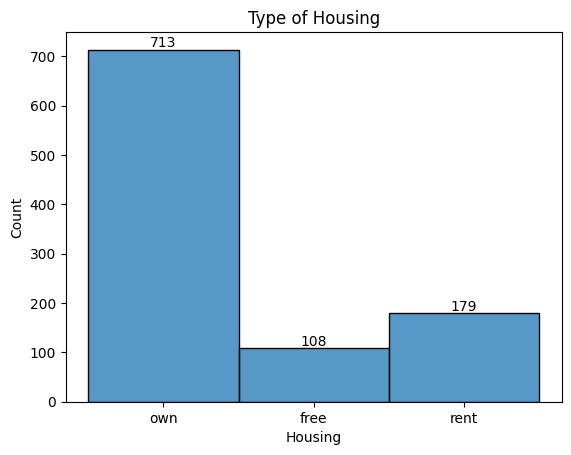

In [18]:
housing_count = credit['Housing'].value_counts()
housing_hist = sns.histplot(credit['Housing'])
plt.title('Type of Housing')
for index, value in housing_count.items():
    housing_hist.text(index, value, f'{value}', ha='center', va='bottom')
plt.show()

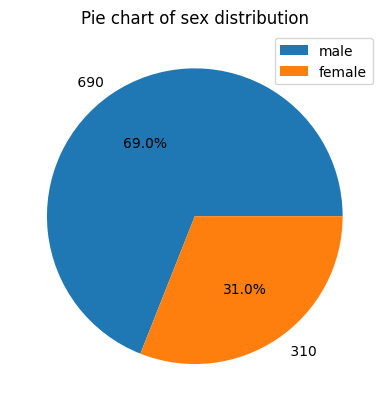

In [19]:
gender_count = credit['Sex'].value_counts()
patches, texts, autotexts = plt.pie(gender_count, autopct='%1.1f%%')
for text, autotext, count in zip(texts, autotexts, gender_count):
    text.set_text(f'{text.get_text()} {count}')

plt.legend(gender_count.index, loc='upper right')
plt.title('Pie chart of sex distribution')
plt.show()

In [20]:
credit['Sex'].value_counts()

Sex
male      690
female    310
Name: count, dtype: int64

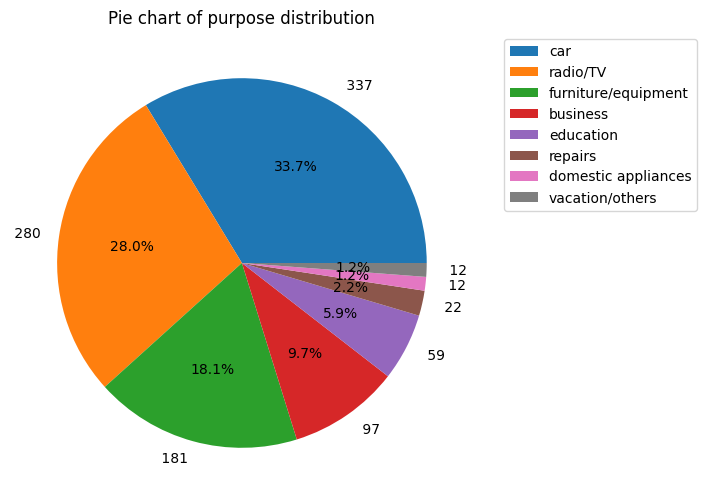

In [21]:
purpose_count = credit['Purpose'].value_counts()
plt.figure(figsize=(12,6))
patches, texts, autotexts = plt.pie(purpose_count, autopct='%1.1f%%')
for text, autotext, count in zip(texts, autotexts, purpose_count):
        text.set_text(f'{text.get_text()} {count}')

plt.legend(purpose_count.index, loc='upper right', bbox_to_anchor=(1.5, 1))
plt.title('Pie chart of purpose distribution')
plt.show()

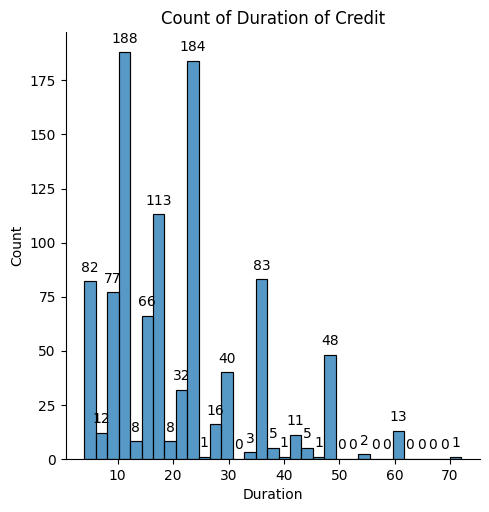

In [22]:
dur_count = credit['Duration'].value_counts()

sns.displot(credit['Duration'],  bins=len(dur_count))
duration_graph = plt.gca()
for p in duration_graph.patches:
    duration_graph.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set title
plt.title('Count of Duration of Credit')
plt.show()

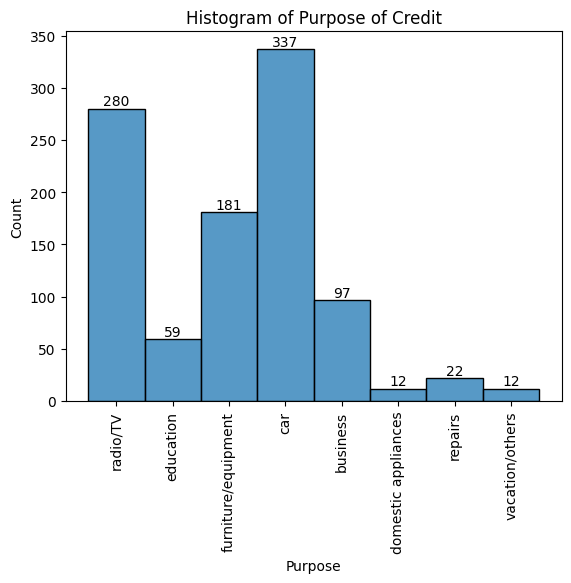

In [23]:
purpose_hist = sns.histplot(credit['Purpose'])
plt.xticks(rotation=90)
plt.title('Histogram of Purpose of Credit')
purpose_count = credit['Purpose'].value_counts()
for index, value in purpose_count.items():
    purpose_hist.text(index, value, f'{value}', ha='center', va='bottom')
plt.show()

In [24]:
credit['Purpose'].value_counts()

Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64

In [25]:
numerical_columns = credit.select_dtypes(include=['int64', 'float64']).columns
num_data = credit[numerical_columns]
num_data = num_data.drop('Job', axis=1)

In [26]:
num_data.describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [27]:

credit_corr = num_data.corr()
credit_corr

,Age,Credit amount,Duration
Age,1.000000,0.032716,-0.036136
Credit amount,0.032716,1.000000,0.624984
Duration,-0.036136,0.624984,1.000000


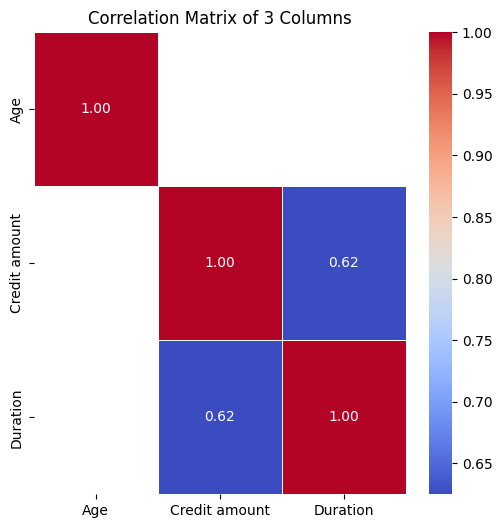

In [28]:
mask = np.abs(credit_corr) <= 0.25
plt.figure(figsize=(6, 6))
sns.heatmap(credit_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation Matrix of 3 Columns')
plt.show()

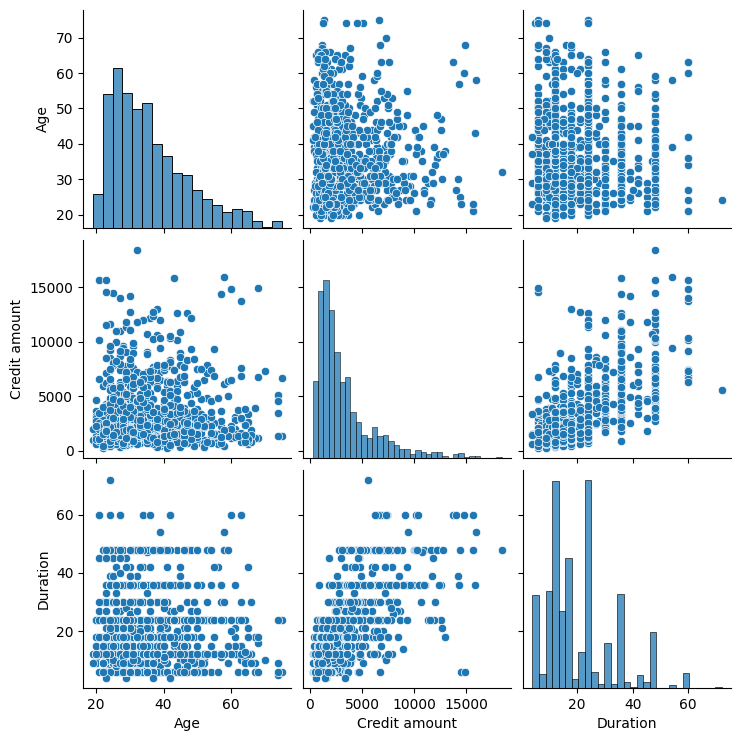

In [29]:
sns.pairplot(credit.drop('Job', axis=1))
plt.show()

Text(0.5, 1.0, 'Histogram of Credit Amount')

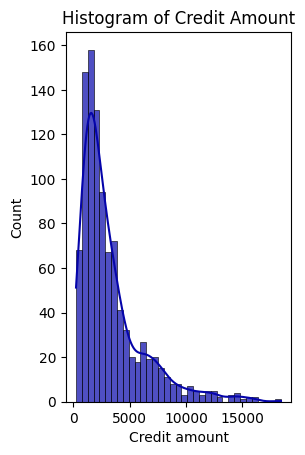

In [30]:
plt.subplot(1, 2, 1)
sns.histplot(credit['Credit amount'], bins='auto', kde=True, color='#0504aa', alpha=0.7)
plt.title('Histogram of Credit Amount')

In [31]:
stat, p_value = shapiro(credit['Credit amount'])
print(f'Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. The data is not normally distributed.")
else:
    print("Fail to reject the null hypothesis. The data appears to be normally distributed.")

Shapiro-Wilk Test Statistic: 0.7933971881866455, p-value: 8.609912964372653e-34
Reject the null hypothesis. The data is not normally distributed.


/var/folders/d3/tyh_8tdj07j5x43s02009nf80000gn/T/ipykernel_1655/3536367766.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Saving accounts', y='Credit amount', data=credit, estimator=np.mean, ci=None)  # Use estimator=np.median for median


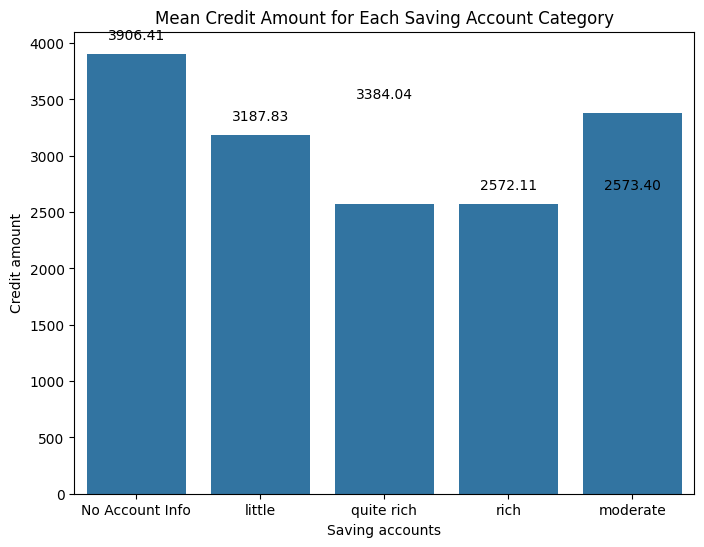

In [32]:
mean_values = credit.groupby('Saving accounts')['Credit amount'].mean().reset_index()

# Plotting the mean credit amount for each category
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Saving accounts', y='Credit amount', data=credit, estimator=np.mean, ci=None)  # Use estimator=np.median for median

# Add mean values to each category
for i, mean_value in enumerate(mean_values['Credit amount']):
    ax.text(i, mean_value + 100, f'{mean_value:.2f}', ha='center', va='bottom')

plt.title('Mean Credit Amount for Each Saving Account Category')
plt.show()

/var/folders/d3/tyh_8tdj07j5x43s02009nf80000gn/T/ipykernel_1655/4111557363.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Checking account', y='Credit amount', data=credit, estimator=np.mean, ci=None)  # Use estimator=np.median for median


Text(0.5, 1.0, 'Mean Credit Amount for Each Checking Account Category')

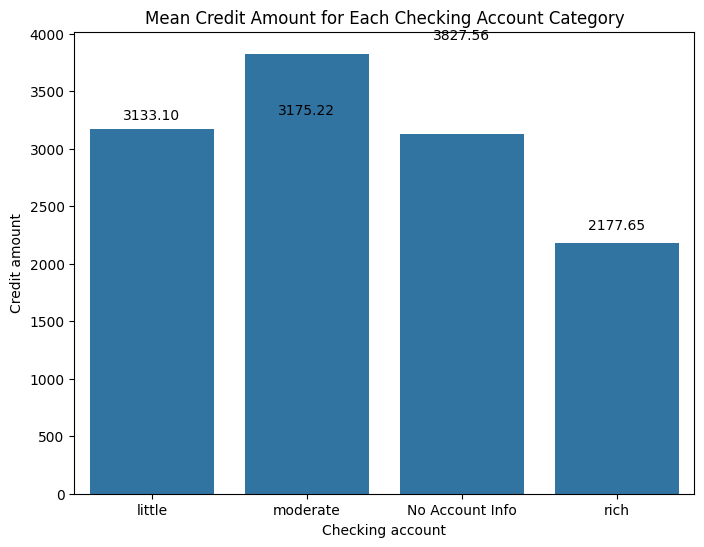

In [33]:
mean_values = credit.groupby('Checking account')['Credit amount'].mean().reset_index()

# Plotting the mean credit amount for each category
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Checking account', y='Credit amount', data=credit, estimator=np.mean, ci=None)  # Use estimator=np.median for median

# Add mean values to each category
for i, mean_value in enumerate(mean_values['Credit amount']):
    ax.text(i, mean_value + 100, f'{mean_value:.2f}', ha='center', va='bottom')

plt.title('Mean Credit Amount for Each Checking Account Category')

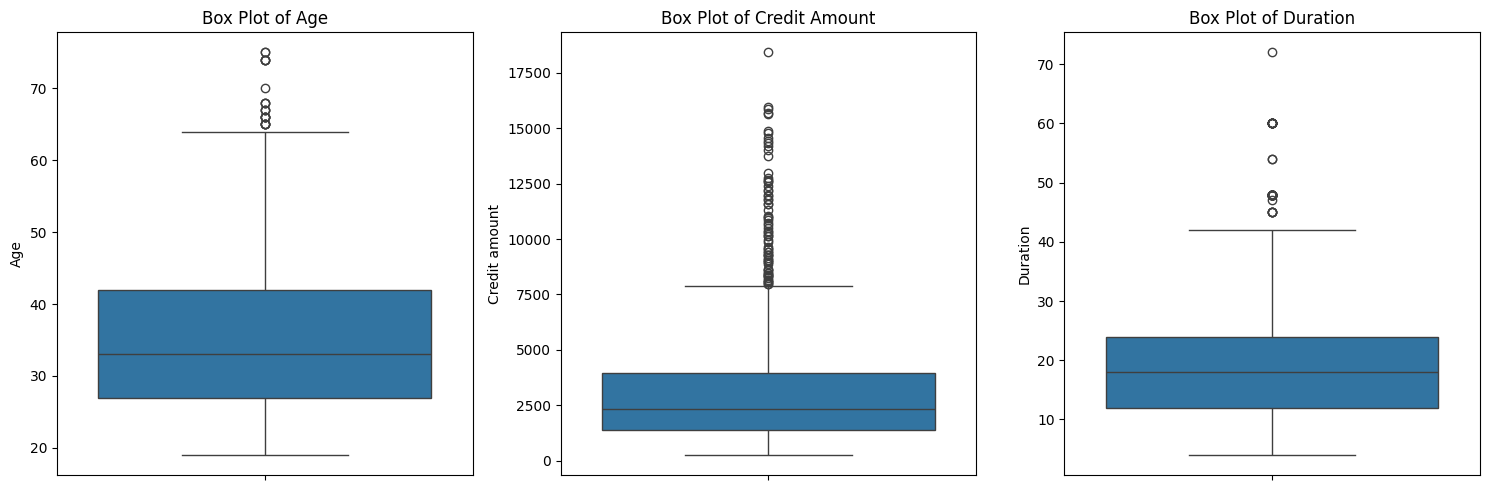

In [34]:
# Box plot for Age
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y='Age', data=credit)
plt.title('Box Plot of Age')

# Box plot for Credit amount
plt.subplot(1, 3, 2)
sns.boxplot(y='Credit amount', data=credit)
plt.title('Box Plot of Credit Amount')

# Box plot for Duration
plt.subplot(1, 3, 3)
sns.boxplot(y='Duration', data=credit)
plt.title('Box Plot of Duration')

plt.tight_layout()
plt.show()

In [35]:

# Assuming 'credit' is your DataFrame
# Select the 'Credit amount' column
credit_amount = credit['Credit amount']

# Calculate the first quartile (Q1)
Q1 = credit_amount.quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = credit_amount.quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_credit = Q1 - 1.5 * IQR
upper_credit = Q3 + 1.5 * IQR

# Identify outliers
outliers = credit_amount[(credit_amount < lower_credit) | (credit_amount > upper_credit)]

# Display the outliers
print(f'Upper bound: {upper_credit}, Lower bound: {lower_credit}')


Upper bound: 7882.375, Lower bound: -2544.625


In [36]:
credit_outlier = credit['Credit amount'] > upper_credit
credit_outlier.value_counts()

Credit amount
False    928
True      72
Name: count, dtype: int64

In [37]:

# Assuming 'credit' is your DataFrame
# Select the 'Credit amount' column
age = credit['Age']

# Calculate the first quartile (Q1)
Q1 = age.quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = age.quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_age = Q1 - 1.5 * IQR
upper_age = Q3 + 1.5 * IQR

# Identify outliers
outliers = age[(age < lower_age) | (age > upper_age)]

# Display the outliers
print(f'Upper bound: {upper_age}, Lower bound: {lower_age}')


Upper bound: 64.5, Lower bound: 4.5


In [38]:
credit_outlier = credit['Age'] > upper_age
credit_outlier.value_counts()

Age
False    977
True      23
Name: count, dtype: int64

In [39]:

# Assuming 'credit' is your DataFrame
# Select the 'Credit amount' column
age = credit['Duration']

# Calculate the first quartile (Q1)
Q1 = age.quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = age.quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_duration = Q1 - 1.5 * IQR
upper_duration = Q3 + 1.5 * IQR

# Identify outliers
outliers = age[(age < lower_duration) | (age > upper_duration)]

# Display the outliers
print(f'Upper bound: {upper_duration}, Lower bound: {lower_duration}')


Upper bound: 42.0, Lower bound: -6.0


In [40]:
credit_outlier = credit['Duration'] > upper_duration
credit_outlier.value_counts()

Duration
False    930
True      70
Name: count, dtype: int64

<Axes: xlabel='Credit amount', ylabel='Duration'>

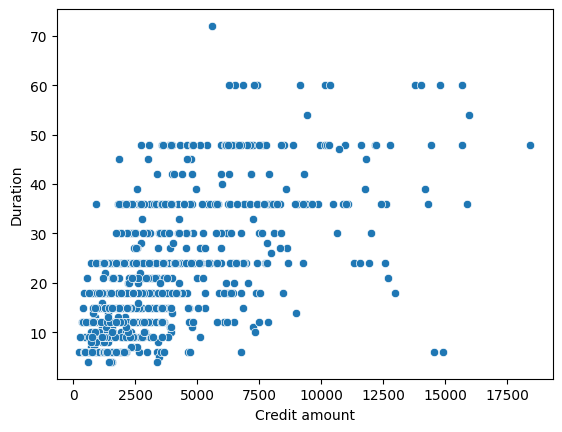

In [41]:
sns.scatterplot(x=credit['Credit amount'], y=credit['Duration'])

In [42]:
purpose_cred_mean = credit.groupby('Purpose')['Credit amount'].mean().reset_index()
purpose_cred_mean

,Purpose,Credit amount
0,business,4158.041237
1,car,3768.192878
2,domestic appliances,1498.000000
3,education,2879.203390
4,furniture/equipment,3066.988950
5,radio/TV,2487.653571
6,repairs,2728.090909
7,vacation/others,8209.333333


<Axes: xlabel='Purpose', ylabel='Credit amount'>

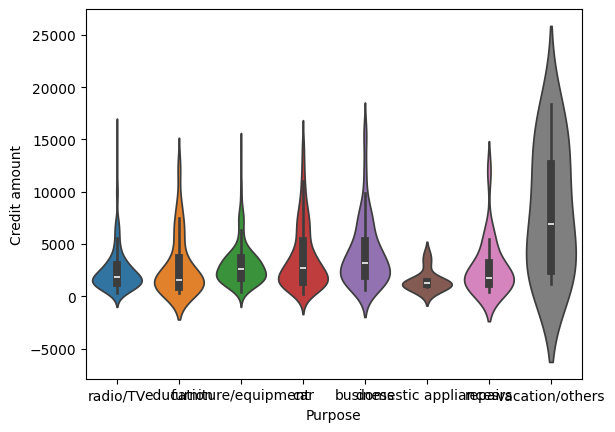

In [43]:
 
sns.violinplot(y=credit['Credit amount'], x=credit['Purpose'], hue=credit['Purpose'])

### Hypothesis Testing

There is a significant different between the average.

H0: There is no significant different in credit amount between different purposes.<br>
H1: There is a significant different in credit amount between different purposes.

In [44]:
from scipy.stats import f_oneway

# Assuming 'credit' is your DataFrame with columns 'Purpose' and 'Credit amount'
# Check the unique values in the 'Purpose' column
unique_purposes = credit['Purpose'].unique()

# Create a dictionary to store credit amounts for each purpose
credit_by_purpose = {purpose: credit[credit['Purpose'] == purpose]['Credit amount'] for purpose in unique_purposes}

# Perform ANOVA
f_statistic, p_value = f_oneway(*credit_by_purpose.values())

# Display the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in credit amount between different purposes.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in credit amount between different purposes.")


F-statistic: 13.34142171179633
P-value: 1.585947764999813e-16
Reject the null hypothesis. There is a significant difference in credit amount between different purposes.


In [57]:
purpose_cred_mean = credit.groupby('Purpose')['Credit amount'].mean().reset_index()

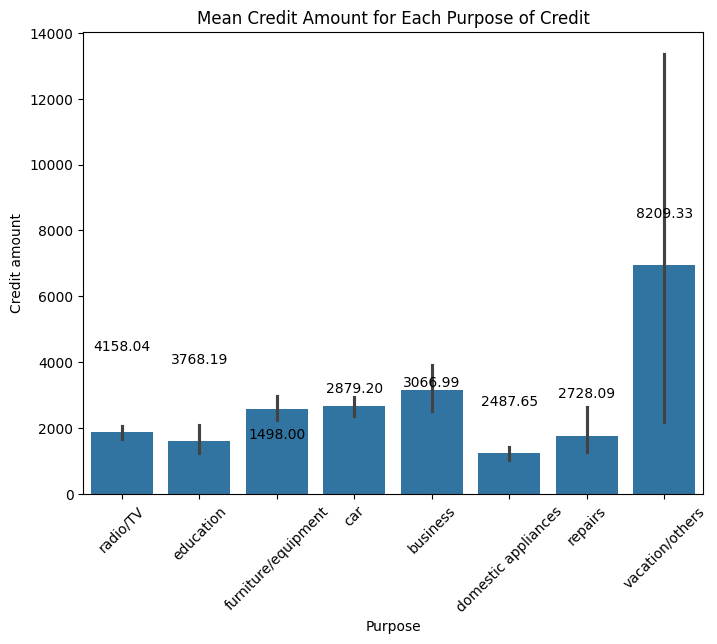

In [58]:
plt.figure(figsize=(8, 6))
bar_mean_pur = sns.barplot(x='Purpose', y='Credit amount', data=credit, estimator=np.median)  # Use estimator=np.median for median
plt.title('Mean Credit Amount for Each Purpose of Credit')
plt.xticks(rotation=45)
for i, purpose_cred_mean in enumerate(purpose_cred_mean['Credit amount']):
    bar_mean_pur.text(i, purpose_cred_mean + 100, f'{purpose_cred_mean:.2f}', ha='center', va='bottom')
plt.show()

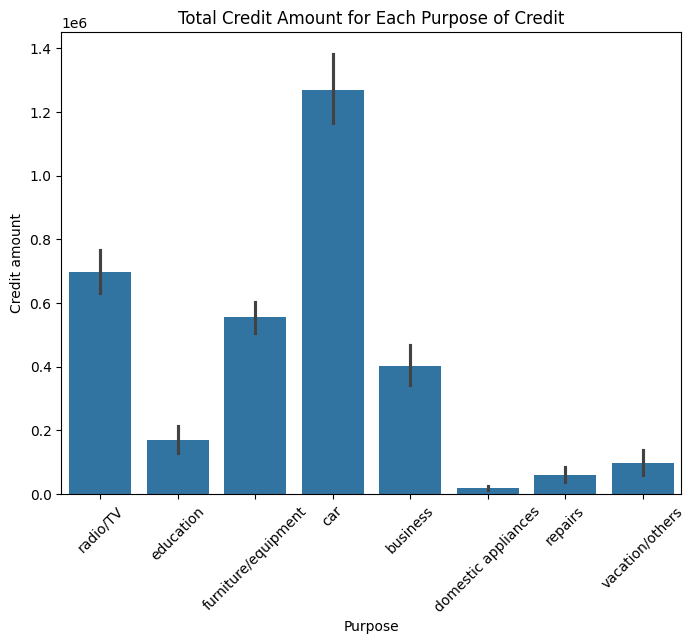

In [59]:
plt.figure(figsize=(8, 6))
bar_mean_pur = sns.barplot(x='Purpose', y='Credit amount', data=credit, estimator=np.sum)
plt.title('Total Credit Amount for Each Purpose of Credit')
plt.xticks(rotation=45)
plt.show()

/var/folders/d3/tyh_8tdj07j5x43s02009nf80000gn/T/ipykernel_1655/2042025160.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=credit, x='Purpose', palette='viridis')


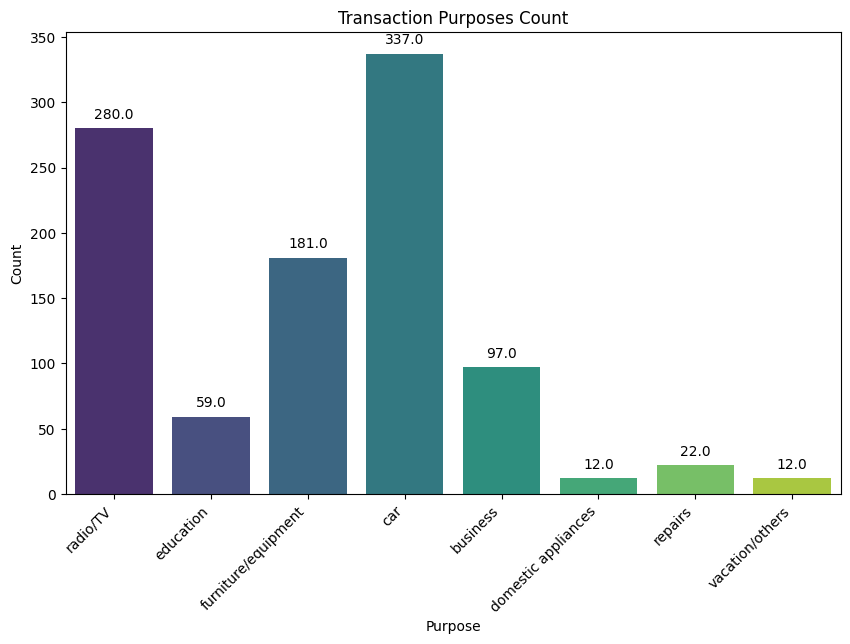

In [60]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=credit, x='Purpose', palette='viridis')
plt.title('Transaction Purposes Count')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()